<a href="https://colab.research.google.com/github/sagar9926/NLP_Specialisation/blob/main/Lenovo_WordCloud_and_Document_Clusteing_using_locality_sensitive_hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
import string
import re
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
import pprint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!wget "https://raw.githubusercontent.com/sagar9926/NLP_Specialisation/main/lenovo.txt"

--2021-06-27 10:27:18--  https://raw.githubusercontent.com/sagar9926/NLP_Specialisation/main/lenovo.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11142106 (11M) [text/plain]
Saving to: ‘lenovo.txt’

lenovo.txt          100%[===================>]  10.62M  21.8MB/s    in 0.5s    

2021-06-27 10:27:19 (21.8 MB/s) - ‘lenovo.txt’ saved [11142106/11142106]



In [3]:
data = pd.read_csv('lenovo.txt')
data.head()

,Customer_Id,Source,Customer_Profile,Age_Group,Gender,Purpose,Product_Type,Comments,Outcome
0,1,SMS,Salaried,22 - 25,Male,Movies,Tablet,Call drop.,Call Disconnected
1,2,Websites,Salaried,22 - 25,Male,Speed Response,Notebook,Call drop,Call Disconnected
2,3,Websites,Salaried,26 - 30,Male,Speed Response,Notebook,"While assisting with the info, Customer discon...",Call Disconnected
3,4,Websites,Salaried,26 - 30,Male,Speed Response,Notebook,Customer had already ordered for G500 and enqu...,Product Specs Enquiry
4,5,Websites,Salaried,22 - 25,Male,Stylish,Tablet,Call disconnected,Call Disconnected


In [4]:
# with open("lenovo.txt",'r') as file:
#   print(file.readline())

# col_str = 'Customer_Id	Source	Customer_Profile	Age_Group	Gender	Purpose	Product_Type	Comments	Outcome'
# col = col_str.split()

# data = pd.DataFrame(columns=col)
# with open("lenovo.txt",'r') as file:
#   for line in file :
#     temp = pd.DataFrame(np.expand_dims(col,axis = 0).tolist(),columns=col)
#     data = pd.concat([data,temp])



In [5]:
def process_text(text):
    """Process text function.
    Input:
        text: a string containing a text
    Output:
        texts_clean: a list of words containing the processed text
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    stopwords_english.append('customer')
    # remove stock market tickers like $GE
    # /$ :  Matches a "$" character (char code 36).
    # /w :  Matches any word character (alphanumeric & underscore).
    # * :  Match 0 or more of the preceding token.
    text = re.sub(r'\$\w*', '', text)

    # remove old style retext text "RT"
    # ^ : Matches the beginning of the string, or the beginning of a line if the multiline flag (m) is enabled.
    # RT : Matches the text RT
    # [ :  Match any character in the set.
        # \s :  Matches any whitespace character (spaces, tabs, line breaks).

    # ]
    # + :  Match 1 or more of the preceding token.
    text = re.sub(r'^RT[\s]+', '', text)

    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    text = re.sub(r'[0-9]*', '',text)
    # tokenize texts
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # texts_clean.append(word)
            #stem_word = stemmer.stem(word)  # stemming word
            texts_clean.append(word)

    return texts_clean

In [6]:
# Generate processed comments :
data['Processed_Comments'] = data['Comments'].apply(lambda text : " ".join(process_text(text)) )

In [7]:
# data_sal = data[data['Customer_Profile'] == 'Salaried']
# data_stu = data[data['Customer_Profile'] == 'Student']
data_out = data[data['Outcome'] == 'Complaint']
data_out = data_out[data_out['Purpose'] == 'Net Surfing']

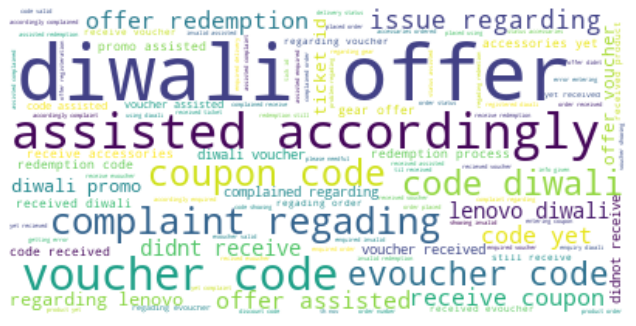

In [8]:
# Start with one review:
text = " ".join(comment for comment in data_out.Processed_Comments)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(10, 12), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")

#You've probably noticed the argument interpolation="bilinear" in the plt.imshow(). 
#This is to make the displayed image appear more smoothly.
plt.axis("off")
plt.show()


## LSH and document search

In [9]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz
from gensim import models

embeddings = models.KeyedVectors.load_word2vec_format(
    '/content/GoogleNews-vectors-negative300.bin', binary=True)

--2021-06-27 10:27:41--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  59.7MB/s    in 28s     

2021-06-27 10:28:09 (56.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [10]:
en_embeddings = embeddings

In [11]:
#Get all comments
all_comments = data.Processed_Comments

In [12]:
en_embeddings_subset = {}
for word in set(" ".join(data.Processed_Comments.tolist()).split()):
  if word in en_embeddings.vocab:
    en_embeddings_subset[word] = en_embeddings[word]

In [13]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    # you have to set this variable to the true label.
    cos = -10
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)

    return cos

In [14]:
# def get_document_similarity(test_doc,doc,en_embeddings):
  
#   doc_sim = 0
#   test_doc = process_text(test_doc)
#   doc = process_text(doc)
#   for test_word in test_doc :

#     test_word_sim = 0

#     for word in doc:
#       simi = cosine_similarity(en_embeddings.get(test_word,np.zeros(300)),en_embeddings.get(word,np.zeros(300)))

#       test_word_sim += 0 if simi is None else simi 

#     doc_sim += (test_word_sim / len(doc))

#   return doc_sim 



In [15]:
# td = 'Notebook,Customer enquired about the do gear offer registeration procedure'
# d = 'Customer had some technical issue so provided with the technical support number'
# get_document_similarity(td,d,en_embeddings_subset)

In [16]:
def get_document_embedding(text,en_embeddings):
    '''
    Input:
        - text: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the text
    '''
    doc_embedding = np.zeros(300)

    processed_doc = process_text(text)

    for word in processed_doc:
      doc_embedding += en_embeddings.get(word,np.zeros(300))
    return doc_embedding

In [17]:
print(len(set(" ".join(data.Processed_Comments.tolist()).split())))
print(len(en_embeddings_subset.keys()))

8631
3363


In [18]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# testing your function
custom_text = all_comments[0]
print(all_comments[0])
text_embedding = get_document_embedding(custom_text, en_embeddings_subset)
text_embedding[-5:]

call drop


array([-0.45019531, -0.26806641,  0.06750488,  0.10302734,  0.02490234])

In [19]:
def get_document_vecs(all_docs, en_embeddings):
    '''
    Input:
        - all_docs: list of strings - all texts in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of text embeddings.
        - ind2Doc_dict: dictionary with indices of text in vecs as keys and their embeddings as the values.
    '''

    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    ind2Doc_dict = {}

    # this is list that will store the document vectors
    document_vec_l = []

    for i, doc in enumerate(all_docs):

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # get the document embedding of the tweet
        doc_embedding = get_document_embedding(doc, en_embeddings)

        # save the document embedding into the ind2Tweet dictionary at index i
        ind2Doc_dict[i] = doc_embedding

        # append the document embedding to the list of document vectors
        document_vec_l.append(ind2Doc_dict[i])

        ### END CODE HERE ###

    # convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_l)

    return document_vec_matrix, ind2Doc_dict

In [20]:
document_vecs, ind2Tweet = get_document_vecs(all_comments, en_embeddings_subset)

In [21]:
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 86410
shape of document_vecs (86410, 300)


In [29]:
#Now you have a vector of dimension (m,d) where m is the number of tweets (10,000) 
#and d is the dimension of the embeddings (300). 
#Now you will input a text, and use cosine similarity to see which text in our corpus is similar to your text

#my_text = all_comments[np.random.randint(0,80000)]
my_text = 'complain'
print("my_text : ",my_text)
process_text(my_text)
text_embedding = get_document_embedding(my_text, en_embeddings_subset)

# this gives you a similar tweet as your input.
#idx = np.argmax(cosine_similarity(document_vecs, text_embedding))
idx = np.argsort(cosine_similarity(document_vecs, text_embedding))[::-1].tolist()[:5]
print("similar text : ",all_comments[idx].values)

my_text :  complain
similar text :  ['used dogear voucher code buy years laptop warranty pack additional paid conformed tablet code cannot used buy laptop warranty informed wil refund sent mail nagesh@ndslindia.com nov reply ready years warranty activate u serial qb recently bought please need full'
 'want extend warranty already passed serial product bp concerned dept lenovo bp got reply lenovo dept.he wants know bp get reply regarding warranty extension.it already months'
 'upset service provided gare months also recive evoucher tiket id-flr ... even afer sending mails got mail send documents really diffcult wait long told give bad feed back inconvineance caused ...'
 'want information yp want purchase let information given shared feedback us improve service support executives verry polite face bitter experience contacted'
 "placed order gear offer recived yet trying check order status showing hold regarding try'd contact delivery department getting responce regarding issue wants spe

In [31]:
N_VECS = len(all_comments)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 86410 and each has 300 dimensions.


In [32]:
# The number of planes. We use log2(625) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

In [33]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

In [34]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # for the set of planes,
    # calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10)
    # The dot product will have the shape (1,10)
    dot_product = np.dot(v,planes)

    # get the sign of the dot product (1,10) shaped vector
    sign_of_dot_product = np.sign(dot_product)

    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    # if the sign is 0, i.e. the vector is in the plane, consider the sign to be positive
    h = sign_of_dot_product>=0

    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)

    # initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i
        hash_value += 2**i *h[i]
    ### END CODE HERE ###

    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [35]:
# UNQ_C18 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


In [36]:
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # number of planes is the number of columns in the planes matrix
    num_of_planes = planes.shape[1]

    # number of buckets is 2^(number of planes)
    num_buckets = 2**num_of_planes

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = {i:[] for i in range(num_buckets)}

    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = {i:[] for i in range(num_buckets)}

    # for each vector in 'vecs'
    for i, v in enumerate(vecs):
        # calculate the hash value for the vector
        h = hash_value_of_vector(v, planes)

        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v)

        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i)

    ### END CODE HERE ###

    return hash_table, id_table

In [37]:
# Creating the hashtables
hash_tables = []
id_tables = []
for universe_id in range(N_UNIVERSES):  # there are 25 hashes
    print('working on hash universe #:', universe_id)
    planes = planes_l[universe_id]
    hash_table, id_table = make_hash_table(document_vecs, planes)
    hash_tables.append(hash_table)
    id_tables.append(id_table)

working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24


In [46]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def nearest_neighbor(v, candidates, k=1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity = cosine_similarity(v,row)

        # append the similarity to the list
        similarity_l.append(cos_similarity)
        
    # sort the similarity list and get the indices of the sorted list
    sorted_ids = np.argsort(similarity_l)#[::-1]

    # get the indices of the k most similar candidate vectors
    k_idx = sorted_ids[-k : ]
    ### END CODE HERE ###
    return k_idx

In [47]:
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=N_UNIVERSES):
    """Search for k-NN using hashes."""
    assert num_universes_to_use <= N_UNIVERSES

    # Vectors that will be checked as possible nearest neighbor
    vecs_to_consider_l = list()

    # list of document IDs
    ids_to_consider_l = list()

    # create a set for ids to consider, for faster checking if a document ID already exists in the set
    ids_to_consider_set = set()

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):

        # get the set of planes from the planes_l list, for this particular universe_id
        planes = planes_l[universe_id]

        # get the hash value of the vector for this set of planes
        hash_value = hash_value_of_vector(v, planes)

        # get the hash table for this particular universe_id
        hash_table = hash_tables[universe_id]

        # get the list of document vectors for this hash table, where the key is the hash_value
        document_vectors_l = hash_table[hash_value]

        # get the id_table for this particular universe_id
        id_table = id_tables[universe_id]

        # get the subset of documents to consider as nearest neighbors from this id_table dictionary
        new_ids_to_consider = id_table[hash_value]

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        # remove the id of the document that we're searching
        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)
            print(f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = document_vectors_l[i]

                # append the new_id (the index for the document) to the list of ids to consider
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)

                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

        ### END CODE HERE ###

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)

    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids

In [72]:
#document_vecs, ind2Tweet
doc_id = 80098
doc_to_search = all_comments[doc_id]
vec_to_search = document_vecs[doc_id]

In [73]:
nearest_neighbor_ids = approximate_knn(
    doc_id, vec_to_search, planes_l, k=10, num_universes_to_use=5)

removed doc_id 80098 of input vector from new_ids_to_search
removed doc_id 80098 of input vector from new_ids_to_search
removed doc_id 80098 of input vector from new_ids_to_search
removed doc_id 80098 of input vector from new_ids_to_search
removed doc_id 80098 of input vector from new_ids_to_search
Fast considering 5941 vecs


In [74]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_comments[neighbor_id]}")

Nearest neighbors for document 80098
Document contents: enquired technical department number assisted accordingly

Nearest neighbor at document id 84406
document contents: post sales query assisted technical department number
Nearest neighbor at document id 80249
document contents: complaint regading regading order thrugh diwali offer assisted accordingly
Nearest neighbor at document id 80050
document contents: enquired technical department number assisted accordingly
Nearest neighbor at document id 80111
document contents: enquired processor speed assisted
Nearest neighbor at document id 59223
document contents: enquired technical department number assisted accordingly
Nearest neighbor at document id 59182
document contents: enquired technical department number assisted accordingly
Nearest neighbor at document id 82290
document contents: willing purchase yoga immidialty assisted accordingly
Nearest neighbor at document id 80103
document contents: enquired technical issue assisted acco